# Wstęp
Zadanie 8 obejmuje zagadnienie segmentacji obrazów i wprowadza konwolucyjne modele o architekturze enkoder-dekoder. Modele takie wykorzystują konwolucje i downsampling aby uzyskać mapę cech o mniejszej rozdzielczości (enkoder), a następnie "dekodują" otrzymaną ją z powrotem do większej rozdzielczości aby wydobyć w rozdzielczości oryginalnego obrazka interesujące nas informacje semantyczne - np. segmentację obrazka na poszczególne obiekty. Architektury tego typu mają również zastosowania w modelach generatywnych, w zadaniach które ogólnie określamy jako *image to image translation*.

# Cel ćwiczenia

Celem ćwiczenia jest poznanie



*   metod upsamplingu w sieciach konwolucyjnych
*   architektur konwolucyjnych o strukturze enkoder-dekoder
*   wykorzystania sieci głębokich w segmentacji danych obrazowych





# Upsampling w sieciach konwolucyjnych

Na laboratorium 5 dowiedzieliśmy się już, że do zmniejszania rozdzielczości mapy cech możemy wykorzystać dwa podejścia - pooling lub warstwę konwolucyjną z odpowiednim parametrem `stride`. Podobnie jest ze zwiększaniem rozdzielczości.

Wersja prostsza, odwrotność poolingu, to `torch.nn.Upsample`. Jest to pozbawiona uczących się parametrów klasa dająca wybór trybu interpolacji.

In [5]:
import torch

upsampler = torch.nn.Upsample(scale_factor=2)

dummy_input = torch.zeros((3, 3, 32, 32))
upsampler(dummy_input).shape

torch.Size([3, 3, 64, 64])

Klasa `torch.nn.ConvTranspose2d` to natomiast ucząca się operacja "odwracania" konwolucji. Jej relacja wymiarów wejście-wyjście powinna być taka, jak wyjście do wejścia dla warstwy `torch.nn.Conv2d` o analogicznych parametrach konstruktora. Innymi słowy, jeśli tensor przepuścimy przez konwolucję, a następnie konwolucję transponowaną, oczekujemy powrotu do początkowej szerokości i wysokości - o ile oczywiście parametry tych dwóch warstw będą się ze sobą zgadzać.

Konwolucja transponowana wprowadza dodatkowy parametr `output_padding`. Jest on potrzebny dlatego, że ze względu na zaokrąglanie wymiarów dla zwyczajnej konwolucji wykorzystującej `stride>1`, na podstawie wymiaru jej wyjścia nie da się jednoznacznie określić wymiaru jej wejścia. Aby spełnić założenie że warstwa `torch.nn.ConvTranspose2d` odwraca zmianę wymiarów której dokonuje `torch.nn.Conv2d`, potrzebny jest więc dodatkowy parametr pozwalający doprecyzować oczekiwany rozmiar. W razie problemów z uzyskaniem właściwego rozmiaru, dokumentacja torcha podaje konkrenty wzór na zależność między parametrami warstwy a szeokością i wysokością jej wyniku.

https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html

In [6]:
upsampler = torch.nn.ConvTranspose2d(3, 3, 2, stride=2)

dummy_input = torch.zeros((3, 3, 32, 32))

print(f"kształt po upsamplingu: {upsampler(dummy_input).shape}")

conv = torch.nn.Conv2d(3, 3, 3, stride=2, padding=1)
deconv = torch.nn.ConvTranspose2d(3, 3, 3, stride=2, padding=1)
fixed_deconv = torch.nn.ConvTranspose2d(3, 3, 3, stride=2, padding=1, output_padding=1)

print(f"kształt po konwolucji: {conv(dummy_input).shape}")
print(
    f"kształt po konwolucji i konw. transponowanej: {deconv(conv(dummy_input)).shape}"
)
print(f"j.w., ale z output_padding: {fixed_deconv(conv(dummy_input)).shape}")

kształt po upsamplingu: torch.Size([3, 3, 64, 64])
kształt po konwolucji: torch.Size([3, 3, 16, 16])
kształt po konwolucji i konw. transponowanej: torch.Size([3, 3, 31, 31])
j.w., ale z output_padding: torch.Size([3, 3, 32, 32])


# Segmentacja obrazu

Model enkoder-dekoder testować będziemy w zadaniu nadzorowanej segmentacji. Oznacza to, że dla obrazu wejściowego musimy znaleźć etykiety ze z góry wyznaczonego zbioru, przewidujemy je jednak nie dla całego obrazu, a na poziomie każdego piksela. Skorzystamy z dostępnego w `torchvision.datasets` zbioru VOC. Najpierw jednak musimy zdefiniować transformację danych, kóra będzie nieco bardziej skomplikowana niż do tej pory.

Ponieważ etykiety są podane również jako obraz, trzeba pamiętać, że augmentacje losowe muszą zgadzać się pomiędzy obrazkiem a etykietą. Niestety, każde wywołanie funkcji w standardowym przepływie danych z wykorzystaniem `transforms` losuje augmentację na nowo. Aby uzyskać identyczną augmentację, konieczne będzie wykorzystanie funkcji z `torchvision.transforms.functional`.

Druga istotna zmiana to konwersja do tensora. Aby zachować `target` jako tensor całkowitoliczbowy, musimy zastosować własną alternatywę dla ToTensor(), jako że `ToTensor` zawsze przekształca obrazy do tensora zmiennmoprzecinkowego w zakresie [0,1].

# Zadanie 1

Zdefiniuj transformację, która dla pary wejściowej `image, target` zwraca zaugmentowane w identyczny sposób obraz i etykiety. Transformacja powinna obejmować:

*   dowolną augmentację na danych wejściowych
*   padding to stałego rozmiaru (w przypadku etykiet, padować trzeba wartością 255)
*   konwersję do tensora - zmiennoprzecinkowego dla obrazu, całkowitoliczbowego dla etykiety

Zdefiniuj również odpowiednią transformację dla zbioru testowego, pamiętając że dane testowe nie powinny byc augmentowane.



In [7]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.transforms import v2
import torchvision.transforms.functional as TF
import numpy as np
import PIL
import random


def pad_to_square(image, fill: int):
    width, height = image.size

    pad_width = max(0, height - width)
    pad_height = max(0, width - height)
    padding = [
        pad_width // 2,
        pad_height // 2,
        pad_width - (pad_width // 2),
        pad_height - (pad_height // 2),
    ]
    squared_image = TF.pad(image, padding, fill)

    return squared_image


resize_to_256 = transforms.Resize((256, 256))


def pair_transforms(image, target):

    # początkowy resize jest dokonany żeby zmniejszyć koszt obliczeniowy na potrzeby ograniczeń laboratorium
    # standardowo pracując na zbiorze nie dokonalibyśmy tego przekształcenia!
    resize = transforms.Resize(
        (image.size[1] // 4, image.size[0] // 4), PIL.Image.NEAREST
    )
    image = resize(image)
    target = resize(target)

    # PADDING TO WHAT TARGET SIZE?
    image_out = pad_to_square(image, 0)
    image_out = resize_to_256(image_out)

    target_out = pad_to_square(target, 255)
    target_out = resize_to_256(target_out)

    # Transform image and target with the same function
    angle = random.randint(-30, 30)
    image_out = TF.rotate(image_out, angle)
    target_out = TF.rotate(target_out, angle)

    # convert to tensor
    to_tensor = transforms.ToTensor()
    image_out = to_tensor(image_out)
    target_out = torch.tensor(np.array(target_out), dtype=torch.int64)

    # ponieważ VOC jest trudnym zbiorem, przedefiniujmy problem
    # zamiast identyfikować wszystkie "rozpoznawalne" obiekty, tworzymy etykiety klasyfikacji tło-obiekt
    target_out = torch.where(
        torch.logical_or(target_out == 0, target_out == 255), target_out, 1
    )

    return image_out, target_out


def test_pair_transforms(image, target):

    resize = transforms.Resize(
        (image.size[1] // 4, image.size[0] // 4), PIL.Image.NEAREST
    )
    image = resize(image)
    target = resize(target)

    # PADDING TO WHAT TARGET SIZE?
    image = pad_to_square(image, 0)
    image = resize_to_256(image)

    target = pad_to_square(target, 255)
    target = resize_to_256(target)

    # convert to tensor
    to_tensor = transforms.ToTensor()
    image = to_tensor(image)
    target = torch.tensor(np.array(target), dtype=torch.int64)

    target = torch.where(torch.logical_or(target == 0, target == 255), target, 1)

    return image, target

Załaduj zbiór danych ze zeefiniowaną transformacją, a następnie zweryfikuj, że augmentacja zgadza się pomiędzy obrazem a etykietą.

In [4]:
data = datasets.VOCSegmentation("root", download=True, transforms=pair_transforms)

Using downloaded and verified file: root/VOCtrainval_11-May-2012.tar
Extracting root/VOCtrainval_11-May-2012.tar to root


In [8]:
test_data = datasets.VOCSegmentation(
    "root", download=True, image_set="val", transforms=test_pair_transforms
)

Using downloaded and verified file: root/VOCtrainval_11-May-2012.tar
Extracting root/VOCtrainval_11-May-2012.tar to root


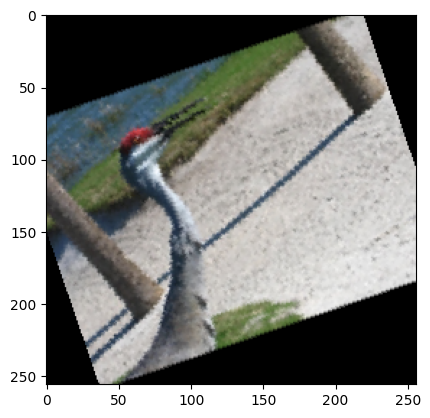

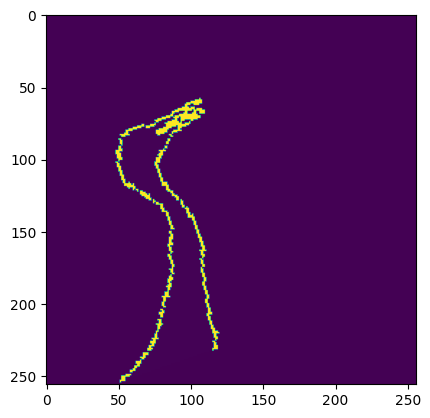

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
torch.Size([3, 256, 256])


In [ ]:
from matplotlib import pyplot as plt

image, label = data[3]
plt.imshow(image.permute(1, 2, 0))
plt.show()
plt.imshow(label)
plt.show()
print(label)

print(image.shape)

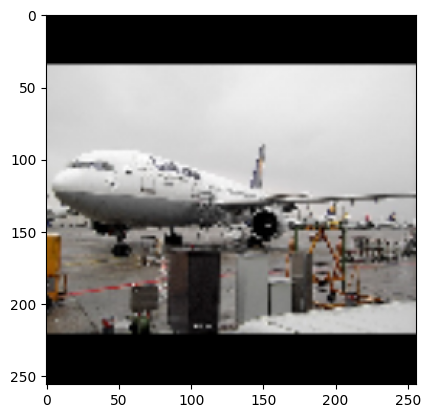

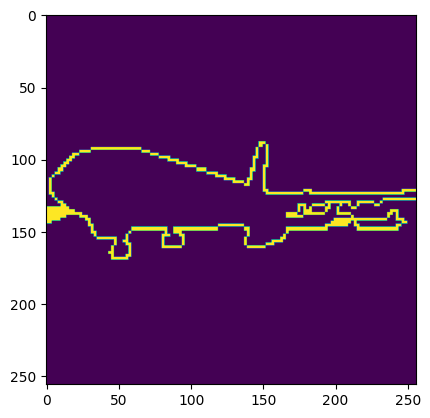

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


In [ ]:
image, label = test_data[0]
plt.imshow(image.permute(1, 2, 0))
plt.show()
plt.imshow(label)
plt.show()
print(label)

Zauważ, że wartością 255 oznaczone są "krawędzie" pomiędzy właściwymi etykietami. Etykieta 255 nie powinna być brana pod uwagę przy wyliczaniu kosztu i metryk jakości segmentacji.

# Architektura enkoder-dekoder


Możemy przejść do zdefiniowania architektury enkoder-dekoder. Achitektura ta powinna przetworzyć obraz do niższej rozdzielczości, a następnie zwiększyć jego wymiar z powrotem do oryginalnego. Podobnie jak w standardowych sieciach konwolucyjnych do klasyfikacji, przydatne jest zwiększanie liczby kanałów wraz ze zmniejszaniem rozdzielczości. Pozwala to na zachowanie informacji po downsamplingu, oraz daje możliwość wyuczenia najbardziej złożonych zależności tam gdzie jest to najbardziej istotne, czyli w warstwach operujących na najniższej rozdzielczości gdzie pole recepcyjne filtra obejmuje największy fragment obrazu. Przy upsamplingu, liczba kanałów typowo będzie się zmniejszać. Dodatkowo, skrótowe połączenia według schematu: pierwsza warstwa do ostatniej, druga do przedostaniej etc. są typowym elementem takich architektur.

# Zadanie 2

Zmodyfikuj funkcję forward klasy SimpleEncoderDecoder tak, aby dodać połączenia skrótowe między warstwami o tej samej rozdzielczości..

In [9]:
from typing import List
import torch


class SimpleEncoderDecoder(torch.nn.Module):
    def __init__(self, channels, out_labels):
        super().__init__()
        self.conv_1 = torch.nn.Conv2d(3, channels[0], 3, padding=1)
        self.conv_2 = torch.nn.Conv2d(channels[0], channels[1], 3, padding=1)
        self.conv_3 = torch.nn.Conv2d(channels[1], channels[2], 3, padding=1)
        self.conv_4 = torch.nn.Conv2d(channels[2], channels[2], 3, padding=1)
        self.up_conv1 = torch.nn.ConvTranspose2d(channels[2], channels[1], 2, stride=2)
        self.up_conv2 = torch.nn.ConvTranspose2d(channels[1], channels[0], 2, stride=2)
        self.up_conv3 = torch.nn.ConvTranspose2d(channels[0], out_labels, 2, stride=2)
        self.pool = torch.nn.MaxPool2d(2)
        self.act = torch.nn.ReLU()
        self.bnorm = torch.nn.BatchNorm2d(channels[2])

        # conv layer to reduce after concatenation of skip connections
        self.reduce_cat1 = torch.nn.Conv2d(
            channels[2] + channels[1], channels[1], 3, padding=1
        )
        self.reduce_cat2 = torch.nn.Conv2d(
            channels[1] + channels[0], channels[0], 3, padding=1
        )
        self.reduce_cat3 = torch.nn.Conv2d(
            channels[0] + out_labels, out_labels, 3, padding=1
        )

    def forward(self, x):
        x1 = self.act(self.conv_1(x))
        # print("1. conv_1 -> ", x1.shape)
        x2 = self.pool(x1)
        # print("2. pool -> ", x2.shape)
        x3 = self.act(self.conv_2(x2))
        # print("3. conv_2 -> ", x3.shape)
        x4 = self.pool(x3)
        # print("4. pool -> ", x4.shape)
        x5 = self.act(self.conv_3(x4))
        # print("5. conv_3 -> ", x5.shape)
        x6 = self.pool(x5)
        # print("6. pool -> ", x6.shape)

        x7 = self.bnorm(x6)
        # print("7. bnorm -> ", x7.shape)

        x8 = self.act(self.conv_4(x7))

        # print("8. conv_4 -> ", x8.shape)

        x = self.up_conv1(x8)
        # print("9. up_conv1 -> ", x.shape)
        # skip connection from x5
        x = torch.cat((x, x5), dim=1)
        # print("9.1. concat -> ", x.shape)
        x = self.act(self.reduce_cat1(x))

        # print("9.2. conv_after_concat -> ", x.shape)

        # skip connection from x3
        x = self.up_conv2(x)
        # print("10. up_conv2 -> ", x.shape)
        x = torch.cat((x, x3), dim=1)
        # print("10.1. concat -> ", x.shape)
        x = self.act(self.reduce_cat2(x))

        # skip connection from x1
        x = self.up_conv3(x)
        # print("11. up_conv3 -> ", x.shape)
        x = torch.cat((x, x1), dim=1)
        # print("11.1. concat -> ", x.shape)
        x = self.act(self.reduce_cat3(x))
        # print("11.2. conv_after_concat -> ", x.shape)

        return x

Zweryfikuj działanie sieci:

In [ ]:
model = SimpleEncoderDecoder([32, 64, 128], 21).cuda()

dummy_data = torch.zeros((32, 3, 64, 64)).cuda()

assert model(dummy_data).shape == (32, 21, 64, 64)

Zdefinujmy kod pomocniczy - jak zwykle można zastąpić własnym, uwzględniającym ulepszenia z poprzednich laboratoriów. Zauważ, że ze funkcja entropii krzyżowej nie wymaga adaptacji do zadania. Natomiast implementacja `count_correct` została zmieniona tak, aby nie zliczać pikseli oznaczonych wartością 255.

In [10]:
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from typing import Tuple
from tqdm import tqdm


def count_correct(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    preds = torch.argmax(y_pred, dim=1)
    not_bg = (y_true != 255).float()
    return ((preds == y_true).float() * not_bg).sum() / not_bg.sum()


def validate(
    model: nn.Module, loss_fn: torch.nn.CrossEntropyLoss, dataloader: DataLoader
) -> Tuple[torch.Tensor, torch.Tensor]:
    loss = 0
    correct = 0
    all = 0
    for X_batch, y_batch in dataloader:
        y_pred = model(X_batch.cuda())
        all += 1
        loss += loss_fn(y_pred, y_batch.cuda()).sum()
        correct += count_correct(y_pred, y_batch.cuda())
    return loss / all, correct / all


def fit(
    model: nn.Module,
    optimiser: optim.Optimizer,
    loss_fn: torch.nn.CrossEntropyLoss,
    train_dl: DataLoader,
    val_dl: DataLoader,
    epochs: int,
    print_metrics: bool = True,
):
    for epoch in range(epochs):
        for X_batch, y_batch in train_dl:
            y_pred = model(X_batch.cuda())
            loss = loss_fn(y_pred, y_batch.cuda())
            loss.backward()
            optimiser.step()
            optimiser.zero_grad()

        if print_metrics:
            model.eval()
            with torch.no_grad():
                train_loss, train_acc = validate(
                    model=model, loss_fn=loss_fn, dataloader=train_dl
                )
                val_loss, val_acc = validate(
                    model=model, loss_fn=loss_fn, dataloader=val_dl
                )
                print(
                    f"Epoch {epoch}: "
                    f"train loss = {train_loss:.3f} (acc: {train_acc:.3f}), "
                    f"validation loss = {val_loss:.3f} (acc: {val_acc:.3f})"
                )

Wyucz sieć na danych z VOCSegmentation.

Uwaga: VOCSegmentation to dość trudny zbiór, nie trzeba tu osiągać wyjątkowo dobrych wyników.



In [ ]:
model = SimpleEncoderDecoder([32, 64, 128], 2).cuda()

loss = torch.nn.CrossEntropyLoss(ignore_index=255)
train_dl = DataLoader(data, batch_size=32, shuffle=True)
test_dl = DataLoader(test_data, batch_size=32)
optimizer = optim.Adam(model.parameters())

fit(model, optimizer, loss, train_dl, test_dl, 50, True)

Epoch 0: train loss = 0.438 (acc: 0.812), validation loss = 0.443 (acc: 0.808)
Epoch 1: train loss = 0.392 (acc: 0.813), validation loss = 0.402 (acc: 0.808)
Epoch 2: train loss = 0.361 (acc: 0.817), validation loss = 0.371 (acc: 0.811)
Epoch 3: train loss = 0.357 (acc: 0.824), validation loss = 0.363 (acc: 0.823)
Epoch 4: train loss = 0.390 (acc: 0.813), validation loss = 0.396 (acc: 0.813)
Epoch 5: train loss = 0.352 (acc: 0.824), validation loss = 0.358 (acc: 0.817)
Epoch 6: train loss = 0.353 (acc: 0.826), validation loss = 0.362 (acc: 0.821)
Epoch 7: train loss = 0.352 (acc: 0.826), validation loss = 0.360 (acc: 0.824)
Epoch 8: train loss = 0.354 (acc: 0.828), validation loss = 0.361 (acc: 0.826)
Epoch 9: train loss = 0.346 (acc: 0.825), validation loss = 0.355 (acc: 0.819)
Epoch 10: train loss = 0.343 (acc: 0.831), validation loss = 0.351 (acc: 0.829)
Epoch 11: train loss = 0.345 (acc: 0.827), validation loss = 0.350 (acc: 0.822)
Epoch 12: train loss = 0.337 (acc: 0.833), validat

# Zadanie 3

Zdefiniuj parametryzowalną klasę EncoderDecoder, umożliwiającą wybór liczby warstw i liczby kanałów w poszczególnych warstwach. Klasa powinna dodawać połączenia skrótowe pomiędzy warstwami w początkowej a końcowej części architektury o tej samej rozdzielczości. Połączenia skrótowe powinny działać przez konkatenację.

Klasa powinna umożlwiać wybór pomiędzy upsamplingiem z wykorzsytaniem `ConvTranspose2D` a `torch.nn.Upsample`. Sprawdź wyniki tej drugiej opcji z parametrami analogicznymi do testów `SimpleEncoderDecoder` na segmentacji VOC.



In [11]:
from typing_extensions import Literal
from typing import List
from pprint import pprint


def sliding_pair(arr: List[int]) -> List[tuple[int, int]]:
    return [(arr[i], arr[i + 1]) for i in range(len(arr) - 1)]


class EncoderBlock(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = torch.nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.pool = torch.nn.MaxPool2d(2)
        self.act = torch.nn.ReLU()

    def forward(self, x: torch.Tensor):
        enc_out = self.act(self.conv(x))
        x = self.pool(enc_out)
        return x, enc_out


class DecoderBlock(torch.nn.Module):
    """
    Decoder block with transposed convolution
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
    ):
        super().__init__()
        self.up_conv = torch.nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2)
        self.act = torch.nn.ReLU()
        self.conv = torch.nn.Conv2d(
            in_channels + out_channels, out_channels, 3, padding=1
        )

    def forward(self, x: torch.Tensor, skip: torch.Tensor):
        x = self.up_conv(x)
        x = torch.cat((x, skip), dim=1)
        x = self.act(self.conv(x))
        return x


class DecoderBlockUpsample(torch.nn.Module):
    """
    Decoder block with upsampling and convolution instead of transposed convolution
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
    ):
        super().__init__()
        self.upsample = torch.nn.Upsample(scale_factor=2, mode="nearest")
        self.conv1 = torch.nn.Conv2d(
            in_channels, out_channels, kernel_size=3, padding=1
        )
        self.act = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(
            in_channels + out_channels, out_channels, 3, padding=1
        )

    def forward(self, x: torch.Tensor, skip: torch.Tensor):
        x = self.upsample(x)
        x = self.conv1(x)
        x = torch.cat((x, skip), dim=1)
        x = self.act(self.conv2(x))
        return x


class SimpleEncoderDecoder2(torch.nn.Module):

    def get_decoder_channels(self, channels: List[int], out_labels: int):
        decoder_outputs = channels[:-1][::-1] + [out_labels]
        decoder_inputs = channels[::-1]
        return list(zip(decoder_inputs, decoder_outputs))

    def __init__(
        self,
        channels: List[int],
        out_labels: int,
        mode: Literal["conv_transpose_2d", "upsample"] = "conv_transpose_2d",
    ):
        super().__init__()

        self.encoder = nn.ModuleList()
        encoder_channels = [3] + channels
        encoder_channels_pairs = sliding_pair(encoder_channels)
        for in_ch, out_ch in encoder_channels_pairs:
            self.encoder.append(EncoderBlock(in_ch, out_ch))

        self.middle_layer = torch.nn.Conv2d(channels[-1], channels[-1], 3, padding=1)

        self.decoder = nn.ModuleList()
        decoder_channels = self.get_decoder_channels(channels, out_labels)
        for in_ch, out_ch in decoder_channels:
            if mode == "conv_transpose_2d":
                layer = DecoderBlock(in_ch, out_ch)
            else:
                layer = DecoderBlockUpsample(in_ch, out_ch)
            self.decoder.append(layer)

        self.pool = torch.nn.MaxPool2d(2)
        self.act = torch.nn.ReLU()
        self.bnorm = torch.nn.BatchNorm2d(channels[-1])

    def forward(self, x):
        x_skip: list = []

        # encoder
        for i, layer in enumerate(self.encoder):
            x, enc_out = layer(x)
            # print(f"enco {i} -> {enc_out.shape}")
            # print(f"pool {i} -> {x.shape}")
            x_skip.append(enc_out)

        # middle
        x = self.bnorm(x)
        # print(f"midd 0 -> {x.shape}")
        x = self.act(self.middle_layer(x))
        # print(f"midd 1 -> {x.shape}")

        # decoder
        for i, layer in enumerate(self.decoder):
            x = layer(x, x_skip[-1 - i])
            # print(f"deco {i} -> {x.shape}")

        return x

In [ ]:
# Validate
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SimpleEncoderDecoder2([32, 64, 128], 21).to(device)
dummy_data = torch.zeros((32, 3, 64, 64)).to(device)
assert model(dummy_data).shape == (32, 21, 64, 64)

In [13]:
model2 = SimpleEncoderDecoder2([32, 64, 128], 2, "upsample").cuda()

loss2 = torch.nn.CrossEntropyLoss(ignore_index=255)
train_dl = DataLoader(data, batch_size=32, shuffle=True)
test_dl = DataLoader(test_data, batch_size=32)
optimizer2 = optim.Adam(model2.parameters())

fit(model2, optimizer2, loss2, train_dl, test_dl, 50, True)

Epoch 0: train loss = 0.423 (acc: 0.812), validation loss = 0.427 (acc: 0.808)
Epoch 1: train loss = 0.360 (acc: 0.814), validation loss = 0.368 (acc: 0.809)
Epoch 2: train loss = 0.357 (acc: 0.820), validation loss = 0.364 (acc: 0.815)
Epoch 3: train loss = 0.348 (acc: 0.825), validation loss = 0.353 (acc: 0.821)
Epoch 4: train loss = 0.347 (acc: 0.830), validation loss = 0.352 (acc: 0.828)
Epoch 5: train loss = 0.351 (acc: 0.823), validation loss = 0.357 (acc: 0.818)
Epoch 6: train loss = 0.338 (acc: 0.830), validation loss = 0.344 (acc: 0.826)
Epoch 7: train loss = 0.337 (acc: 0.833), validation loss = 0.340 (acc: 0.833)
Epoch 8: train loss = 0.335 (acc: 0.836), validation loss = 0.342 (acc: 0.833)
Epoch 9: train loss = 0.332 (acc: 0.836), validation loss = 0.338 (acc: 0.833)
Epoch 10: train loss = 0.333 (acc: 0.838), validation loss = 0.340 (acc: 0.835)
Epoch 11: train loss = 0.326 (acc: 0.841), validation loss = 0.332 (acc: 0.837)
Epoch 12: train loss = 0.345 (acc: 0.837), validat